In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random, math, copy

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_arms = 3

# Oracle theta of each arm
theta = np.array([0.7, 0.5, 0.4])

# Problem 2: Implement classical bandit algorithms 

## 1. The epsilon-greedy Algorithm

In [80]:
def epsilon_greedy(epsilon, N, theta):
    """
    Implement the epsilon-greedy algorithm for a Bernoulli bandit problem.

    Parameters
    ----------
    epsilon : float
        The probability of exploration.
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.

    Returns
    -------
    total_reward : float
        Total reward accumulated over N time steps.
    """
    Q = np.zeros(num_arms)  # Estimated values for each arm
    counts = np.zeros(num_arms)  # Count of how many times each arm is pulled
    total_reward = 0  # Total reward tracker

    # Initialization: Pull each arm once
    for arm in range(num_arms):
        reward = 1 if np.random.rand() < theta[arm] else 0
        counts[arm] = 1
        Q[arm] = reward
        total_reward += reward

    # Main loop: Epsilon-greedy exploration and exploitation
    for t in range(num_arms, N):
        if np.random.rand() < epsilon:
            # Exploration: choose a random arm
            arm = np.random.randint(num_arms)
        else:
            # Exploitation: choose the arm with the highest estimated value
            arm = np.argmax(Q)
        
        # Simulate pulling the chosen arm
        reward = 1 if np.random.rand() < theta[arm] else 0
        
        counts[arm] += 1
        Q[arm] += (1 / counts[arm]) * (reward - Q[arm])
        
        total_reward += reward
    
    return total_reward

## 2. The UCB (Upper Confidence Bound) Algorithm

In [81]:
def ucb(c, N, theta):
    """
    Implement the UCB (Upper Confidence Bound) algorithm for a Bernoulli bandit problem.
    
    Parameters
    ----------
    c : float
        Confidence level parameter for the UCB algorithm.
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.
    
    Returns
    -------
    rewards_history : array
        The rewards obtained at each time step.
    """

    Q = np.zeros(num_arms)
    counts = np.zeros(num_arms)
    total_reward = 0
    
    # Initialize by pulling each arm once
    for arm in range(num_arms):
        reward = 1 if np.random.rand() < theta[arm] else 0
        Q[arm] = reward
        counts[arm] = 1
        total_reward += reward

    for t in range(num_arms+1, N+1):
        # Avoid division by zero because each arm was pulled once
        ucb_values = Q + c * np.sqrt((2*np.log(t))/counts)
        arm = np.argmax(ucb_values)
        reward = 1 if np.random.rand() < theta[arm] else 0
        counts[arm] += 1
        Q[arm] += (1/counts[arm])*(reward - Q[arm])
        total_reward += reward
    return total_reward

## 3. TS (Thompson Sampling) Algorithm

In [82]:
from scipy.stats import beta

def thompson_sampling(N, theta, alpha_init, beta_init):
    """
    Implement the Thompson Sampling (TS) algorithm for a Bernoulli bandit problem.
    
    Parameters
    ----------
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.
    alpha_init : array-like
        Initial alpha parameters for the Beta distributions of each arm.
    beta_init : array-like
        Initial beta parameters for the Beta distributions of each arm.
    
    Returns
    -------
    rewards_history : array
        The rewards obtained at each time step.
    """
    alpha = alpha_init.copy()
    beta_ = beta_init.copy()
    total_reward = 0
    for t in range(N):
        sampled_thetas = [np.random.beta(alpha[j], beta_[j]) for j in range(num_arms)]
        arm = np.argmax(sampled_thetas)
        reward = 1 if np.random.rand() < theta[arm] else 0
        total_reward += reward
        alpha[arm] += reward
        beta_[arm] += 1 - reward
    return total_reward


# Problem 3: Each experiment lasts for $N = 5000$ time slots, and we run each experiment $200$ trials. Results are averaged over these $200$ independent trials.

In [83]:
# Parameters
N = 5000
num_trials = 200
epsilons = [0.1, 0.5, 0.9]
cs = [1, 5, 10]

# Two sets of prior parameters for TS
# Set 1: (1,1), (1,1), (1,1)
alpha_set_1 = np.array([1, 1, 1])
beta_set_1 = np.array([1, 1, 1])

# Set 2: (601,401), (401,601), (2,3)
alpha_set_2 = np.array([601, 401, 2])
beta_set_2 = np.array([401, 601, 3])

# True parameters of the arms (as per the oracle, but not known to the algorithm)
theta = np.array([0.7, 0.5, 0.4])

In [84]:
# Epsilon-greedy
print("Epsilon-greedy results:")
for eps in epsilons:
    rewards = []
    for _ in range(num_trials):
        rewards.append(epsilon_greedy(eps, N, theta))
    mean_reward = np.mean(rewards)
    print(f"Epsilon = {eps}, Average total reward over {num_trials} trials: {mean_reward}")

Epsilon-greedy results:
Epsilon = 0.1, Average total reward over 200 trials: 3408.44
Epsilon = 0.5, Average total reward over 200 trials: 3085.66
Epsilon = 0.9, Average total reward over 200 trials: 2748.215


In [85]:
# UCB
print("\nUCB results:")
for c_val in cs:
    rewards = []
    for _ in range(num_trials):
        rewards.append(ucb(c_val, N, theta))
    mean_reward = np.mean(rewards)
    print(f"c = {c_val}, Average total reward over {num_trials} trials: {mean_reward}")


UCB results:
c = 1, Average total reward over 200 trials: 3408.315
c = 5, Average total reward over 200 trials: 2979.74
c = 10, Average total reward over 200 trials: 2829.24


In [86]:
# Thompson Sampling
print("\nThompson Sampling results:")
rewards_set_1 = []
for _ in range(num_trials):
    rewards_set_1.append(thompson_sampling(N, theta, alpha_set_1, beta_set_1))
mean_set_1 = np.mean(rewards_set_1)
print(f"Set 1 Priors (1,1),(1,1),(1,1), Average total reward: {mean_set_1}")

rewards_set_2 = []
for _ in range(num_trials):
    rewards_set_2.append(thompson_sampling(N, theta, alpha_set_2, beta_set_2))
mean_set_2 = np.mean(rewards_set_2)
print(f"Set 2 Priors (601,401),(401,601),(2,3), Average total reward: {mean_set_2}")



Thompson Sampling results:
Set 1 Priors (1,1),(1,1),(1,1), Average total reward: 3480.75
Set 2 Priors (601,401),(401,601),(2,3), Average total reward: 3492.41


# Problem 4

## 4.1 Find the optimal results for each algorithm

Best epsilon: 0.03
Maximum average total reward: 3457.02


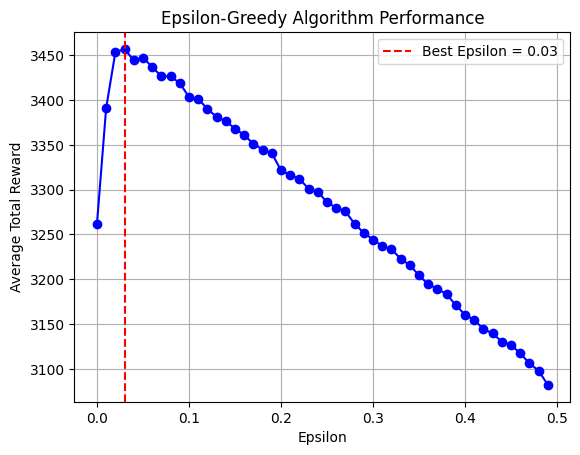

In [94]:
num_trials = 100

epsilon_values = np.arange(0, 0.5, 0.01)
average_rewards = []

for eps in epsilon_values:
    rewards = []
    for _ in range(num_trials):
        rewards.append(epsilon_greedy(eps, N, theta))
    average_rewards.append(np.mean(rewards))

# Find the best epsilon
best_epsilon = epsilon_values[np.argmax(average_rewards)]
print(f"Best epsilon: {best_epsilon:.2f}")
print(f"Maximum average total reward: {np.max(average_rewards):.2f}")

# Plot the results
import matplotlib.pyplot as plt

plt.plot(epsilon_values, average_rewards, marker='o', linestyle='-', color = 'b')
plt.axvline(x=best_epsilon, color='r', linestyle='--', label=f'Best Epsilon = {best_epsilon:.2f}')
plt.xlabel('Epsilon')
plt.ylabel('Average Total Reward')
plt.title('Epsilon-Greedy Algorithm Performance')
plt.legend()
plt.grid(True)
plt.show()


Best c value: 0.40
Maximum average total reward: 3483.90


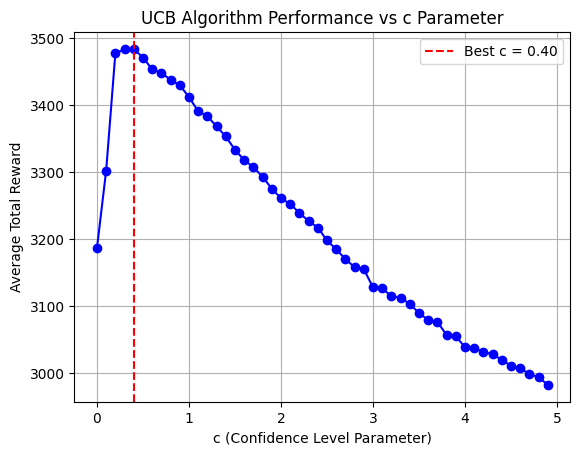

In [93]:
c_values = np.arange(0, 5, 0.1)
average_rewards = []

# Run UCB for each value of c and compute the average reward over multiple trials
for c in c_values:
    rewards = []
    for _ in range(num_trials):
        total_reward = ucb(c, N, theta)
        rewards.append(total_reward)
    average_rewards.append(np.mean(rewards))

# Identify the best c
best_c_index = np.argmax(average_rewards)
best_c = c_values[best_c_index]
best_average_reward = average_rewards[best_c_index]

print(f"Best c value: {best_c:.2f}")
print(f"Maximum average total reward: {best_average_reward:.2f}")

# Plot the results
plt.plot(c_values, average_rewards, marker='o', linestyle='-', color='b')
plt.axvline(x=best_c, color='r', linestyle='--', label=f'Best c = {best_c:.2f}')
plt.xlabel('c (Confidence Level Parameter)')
plt.ylabel('Average Total Reward')
plt.title('UCB Algorithm Performance vs c Parameter')
plt.legend()
plt.grid(True)
plt.show()

# Problem 6

In [2]:
from itertools import product

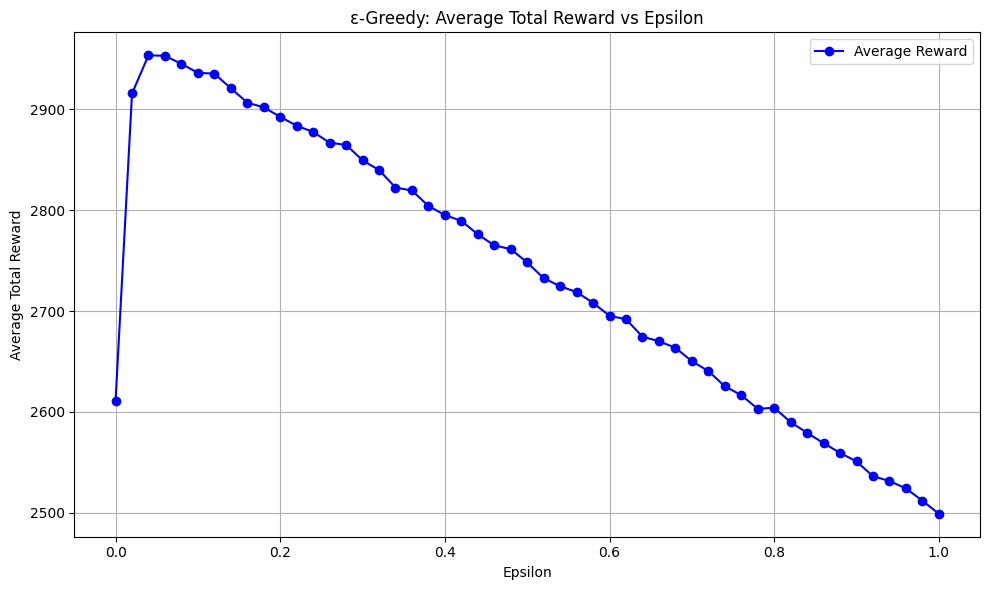

Best epsilon: 0.04
Maximum average total reward: 2953.50


In [15]:
# Initialize global variables for counts and estimated thetas
count = [0, 0, 0]
theta = [0.0, 0.0, 0.0]

def init_greedy():
    """
    Initializes the counts and estimated thetas for the greedy algorithm.
    """
    global count, theta
    count = [0, 0, 0]  # Reset counts for arms 0, 1, 2
    theta = [0.0, 0.0, 0.0]  # Reset estimated thetas

def greedy_dependence(n, epsilon, theta_oracled):
    global count, theta
    init_greedy()  # Initialize counts and estimates
    total_reward = 0  # Total actual rewards obtained

    for t in range(n):
        prob = random.random()  # Generate a random number in [0,1)
        
        if prob < epsilon:
            # Explore: choose a random arm from {0,1,2}
            arm = random.randint(0, 2)
        else:
            # Exploit: choose the arm with the highest estimated theta
            arm = np.argmax(theta)
            if theta[arm] == 0:
                # If all estimated thetas are 0, choose a random arm
                arm = random.randint(0, 2)

        # Simulate pulling the chosen arm: reward is 1 with probability theta_oracled[arm]
        r_i = np.random.binomial(1, theta_oracled[arm])

        # Accumulate the actual reward
        total_reward += r_i

        # Update counts and estimated thetas using incremental averaging
        count[arm] += 1
        theta[arm] += (r_i - theta[arm]) / count[arm]

        # Enforce dependency: Update theta[0] based on theta[1] and theta[2]
        theta[0] = 0.5 * theta[1] + 0.5 * theta[2]
        # Ensure theta[0] remains within [0,1]
        theta[0] = min(max(theta[0], 0.0), 1.0)

    return total_reward

# Define the true reward probabilities based on the dependency
theta1_true = 0.6
theta2_true = 0.4
theta0_true = 0.5 * theta1_true + 0.5 * theta2_true  # θ0 = 0.5*θ1 + 0.5*θ2 = 0.5*0.6 + 0.5*0.4 = 0.3 + 0.2 = 0.5

# Ensure that theta0_true is within [0,1]
theta0_true = min(max(theta0_true, 0.0), 1.0)

theta_oracled = [theta0_true, theta1_true, theta2_true]

# Experiment Parameters
epsilon_values = np.arange(0, 1.02, 0.02)
repeat_time = 100  # Number of trials for each epsilon
N = 5000  # Number of time steps per trial

rewards = np.zeros(len(epsilon_values))  # Average rewards for each epsilon

# Run experiments for each epsilon
for i, eps in enumerate(epsilon_values):
    for trial in range(repeat_time):
        reward = greedy_dependence(N, eps, theta_oracled)
        rewards[i] += reward / repeat_time

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Average Total Reward vs. Epsilon
plt.plot(epsilon_values, rewards, marker='o', linestyle='-', color='blue', label='Average Reward')
plt.scatter(epsilon_values, rewards, color='red', s=10)
plt.xlabel('Epsilon')
plt.ylabel('Average Total Reward')
plt.title('ε-Greedy: Average Total Reward vs Epsilon')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Identify and print the best epsilon based on rewards
best_index = np.argmax(rewards)
best_epsilon = epsilon_values[best_index]
best_reward = rewards[best_index]
print(f"Best epsilon: {best_epsilon:.2f}")
print(f"Maximum average total reward: {best_reward:.2f}")

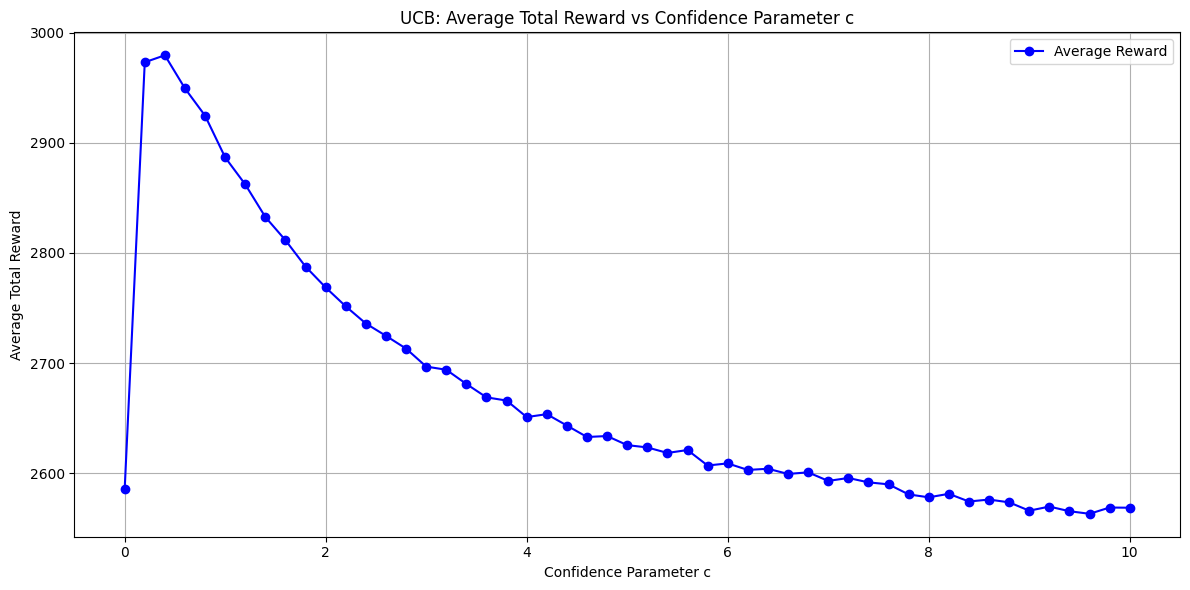

Best c: 0.40
Maximum average total reward: 2979.58


In [16]:
def ucb_dependence(c, N, theta_oracled):
    num_arms = 3
    Q = np.zeros(num_arms)          # Estimated rewards for each arm
    counts = np.zeros(num_arms)     # Number of times each arm has been pulled
    total_reward = 0                 # Total accumulated reward

    # Initialize by pulling each arm once
    for arm in range(num_arms):
        reward = 1 if random.random() < theta_oracled[arm] else 0
        Q[arm] = reward
        counts[arm] = 1
        total_reward += reward

        # Enforce dependency after initial pulls of arm1 and arm2
        if arm == 1 or arm == 2:
            Q[0] = 0.5 * Q[1] + 0.5 * Q[2]
            Q[0] = min(max(Q[0], 0.0), 1.0)  # Ensure within [0,1]

    # Run UCB algorithm for remaining time steps
    for t in range(num_arms + 1, N + 1):
        # Compute UCB values for each arm
        ucb_values = Q + c * np.sqrt((2 * np.log(t)) / counts)
        arm = np.argmax(ucb_values)

        # Pull the selected arm and observe the reward
        reward = 1 if random.random() < theta_oracled[arm] else 0
        total_reward += reward

        # Update counts and estimated rewards
        counts[arm] += 1
        Q[arm] += (1 / counts[arm]) * (reward - Q[arm])

        # Enforce dependency: Update theta0 based on updated Q1 and Q2
        Q[0] = 0.5 * Q[1] + 0.5 * Q[2]
        Q[0] = min(max(Q[0], 0.0), 1.0)  # Ensure within [0,1]

    return total_reward

# Define the true reward probabilities based on the dependency
theta1_true = 0.6
theta2_true = 0.4
theta0_true = 0.5 * theta1_true + 0.5 * theta2_true

# Ensure that theta0_true is within [0,1]
theta0_true = min(max(theta0_true, 0.0), 1.0)

theta_oracled = [theta0_true, theta1_true, theta2_true]  # [θ0, θ1, θ2]

# Experiment Parameters
c_values = np.arange(0.0, 10.2, 0.2)
repeat_time = 100  # Number of trials for each c
N = 5000  # Number of time steps per trial

average_rewards = np.zeros(len(c_values))  # Average rewards for each c

# Run experiments for each c
for i, c in enumerate(c_values):
    for trial in range(repeat_time):
        reward = ucb_dependence(c, N, theta_oracled)
        average_rewards[i] += reward / repeat_time

# Plot the results
plt.figure(figsize=(12, 6))

# Plot Average Total Reward vs. Confidence Parameter c
plt.plot(c_values, average_rewards, marker='o', linestyle='-', color='blue', label='Average Reward')
plt.scatter(c_values, average_rewards, color='red', s=10)
plt.xlabel('Confidence Parameter c')
plt.ylabel('Average Total Reward')
plt.title('UCB: Average Total Reward vs Confidence Parameter c')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Identify and print the best c based on rewards
best_index = np.argmax(average_rewards)
best_c = c_values[best_index]
best_reward = average_rewards[best_index]
print(f"Best c: {best_c:.2f}")
print(f"Maximum average total reward: {best_reward:.2f}")

In [7]:
def thompson_sampling_dependence(N, theta_oracled, alpha_init, beta_init):
    num_arms = 3
    alpha = alpha_init.copy()
    beta = beta_init.copy()
    total_reward = 0
    
    for t in range(N):
        # Sample model
        sampled_thetas = [np.random.beta(alpha[j], beta[j]) for j in range(num_arms)]
        
        # Select and pull the arm
        arm = np.argmax(sampled_thetas)
        
        # Simulate pulling the selected arm: reward is 1 with probability theta_oracled[arm]
        reward = 1 if np.random.random() < theta_oracled[arm] else 0
        total_reward += reward
        
        # Update the distribution
        alpha[arm] += reward
        beta[arm] += (1 - reward)
    
    return total_reward

In [8]:
def dependency_aware_thompson_sampling(N, theta, alpha_init, beta_init, lam):
    alpha = alpha_init.copy()
    beta = beta_init.copy()
    total_reward = 0.0
    
    for _ in range(N):
        # Sample from each arm's Beta distribution
        sampled_thetas = [np.random.beta(alpha[i], beta[i]) for i in range(3)]
        
        # Select the arm with the highest sampled theta
        arm = np.argmax(sampled_thetas)
        
        # Pull the chosen arm and observe reward
        reward = 1 if random.random() < theta[arm] else 0
        total_reward += reward
        
        # Update the chosen arm's parameters
        alpha[arm] += reward
        beta[arm] += (1 - reward)
        
        # If arm 0 is chosen, also update arms 1 and 2 proportionally
        if arm == 0:
            alpha[1] += lam * reward
            beta[1] += lam * (1 - reward)
            alpha[2] += lam * reward
            beta[2] += lam * (1 - reward)
    
    return total_reward

===== Thompson Sampling Dependence=====
Best Parameters:
Alpha1=201, Alpha2=1, Beta1=601, Beta2=3, Avg Reward=2996.08

===== Dependency-Aware Thompson Sampling=====
Best Parameters:
Alpha1=1, Alpha2=2, Beta1=201, Beta2=3, Avg Reward=3009.12


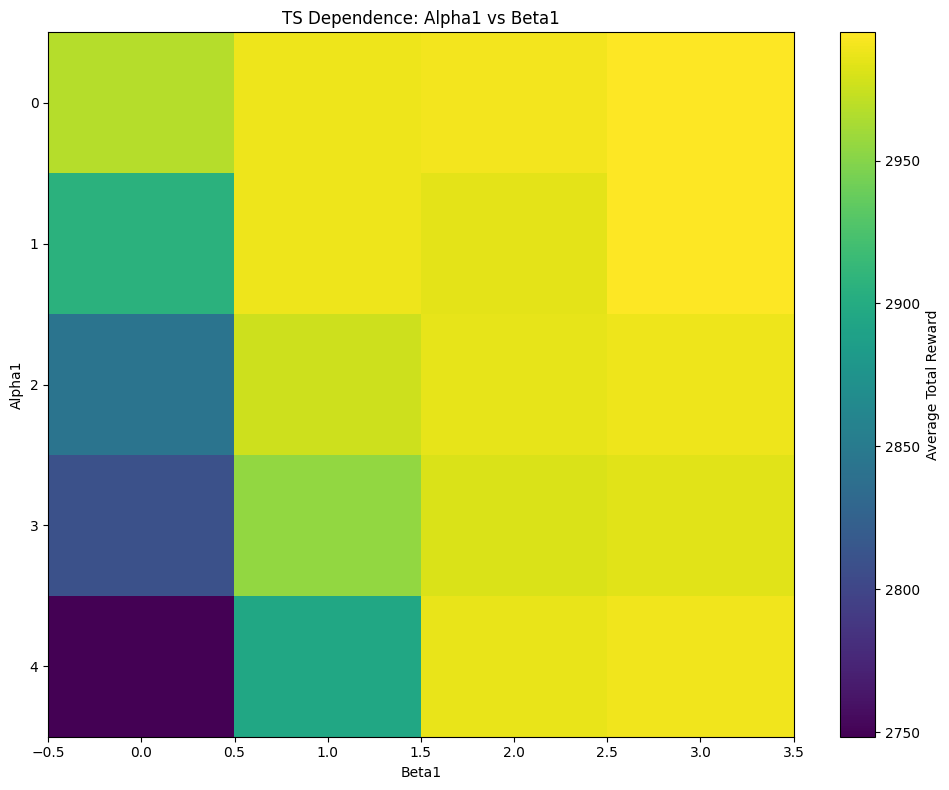

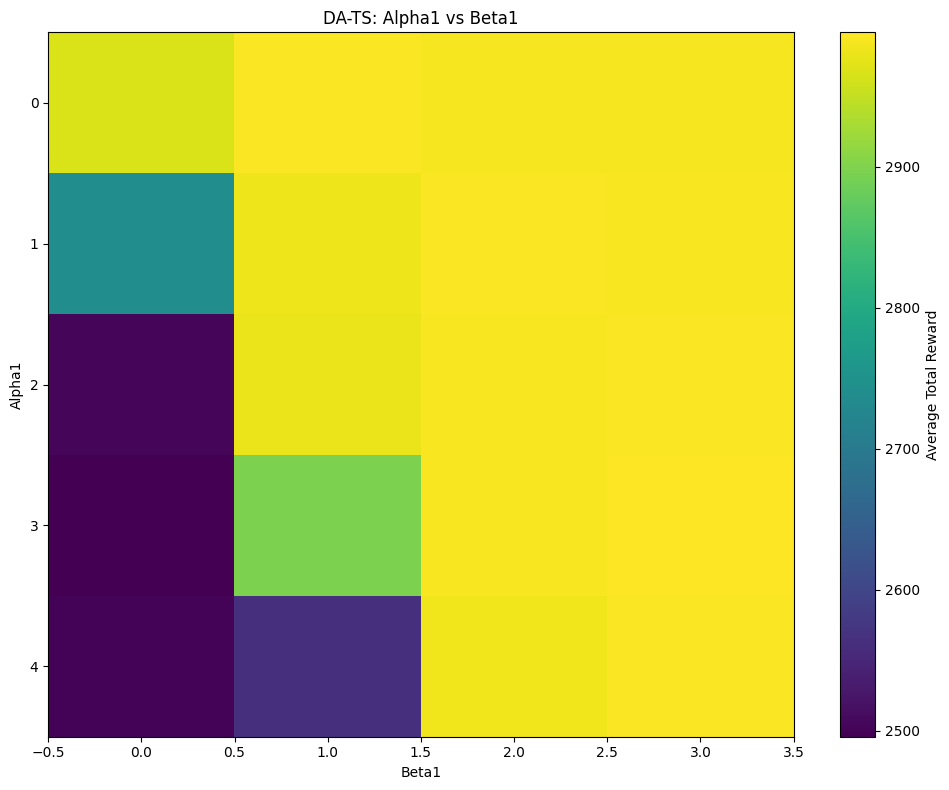

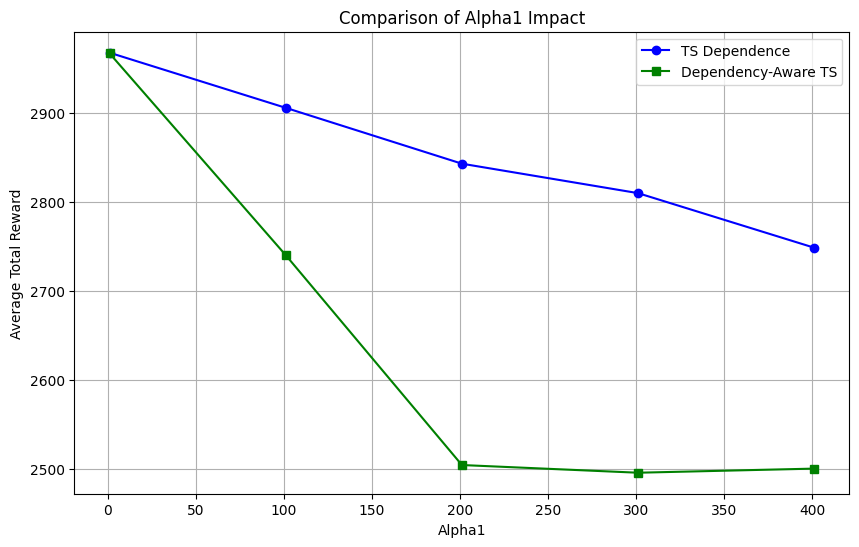

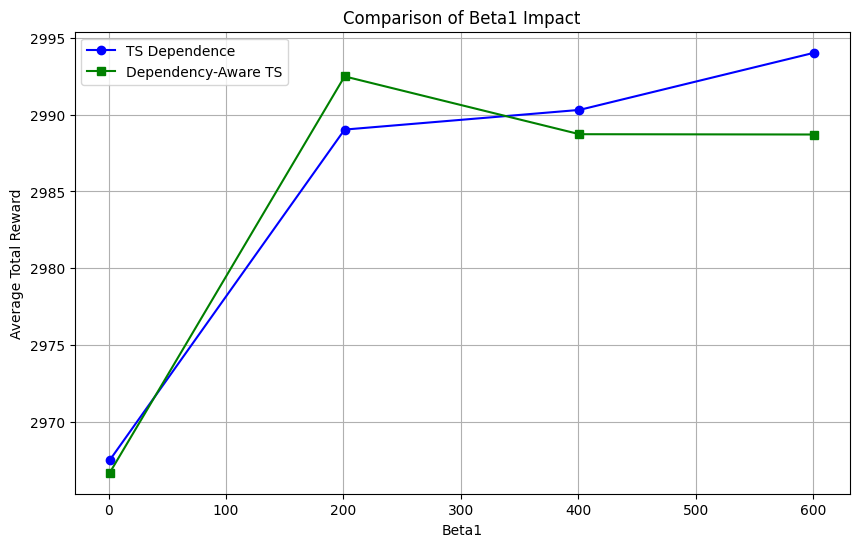

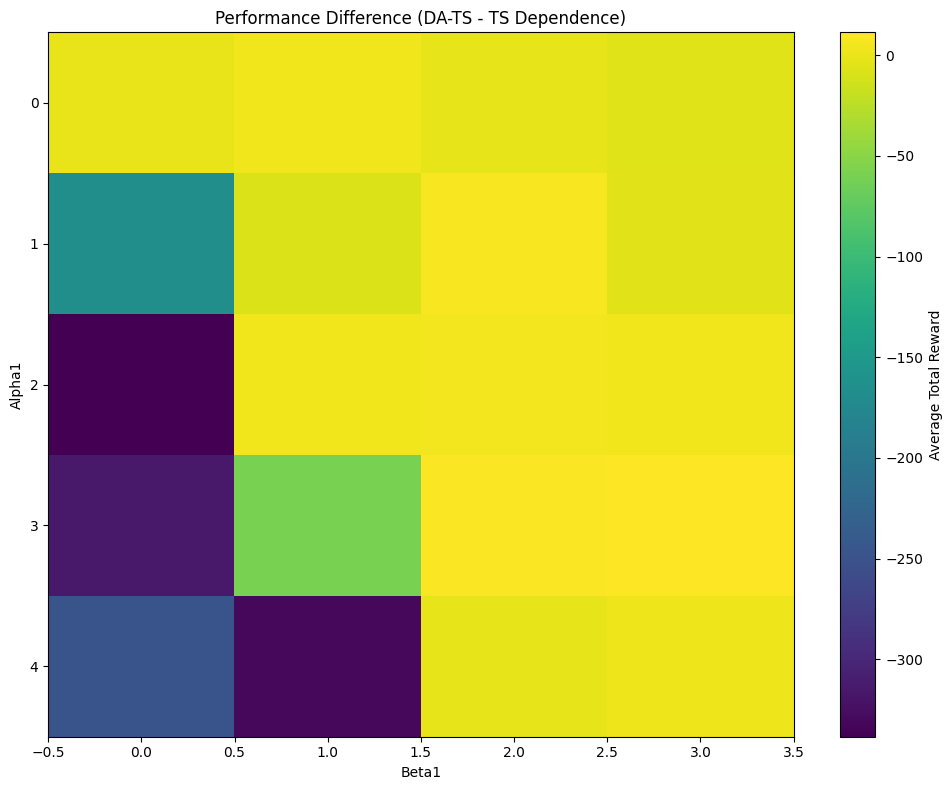

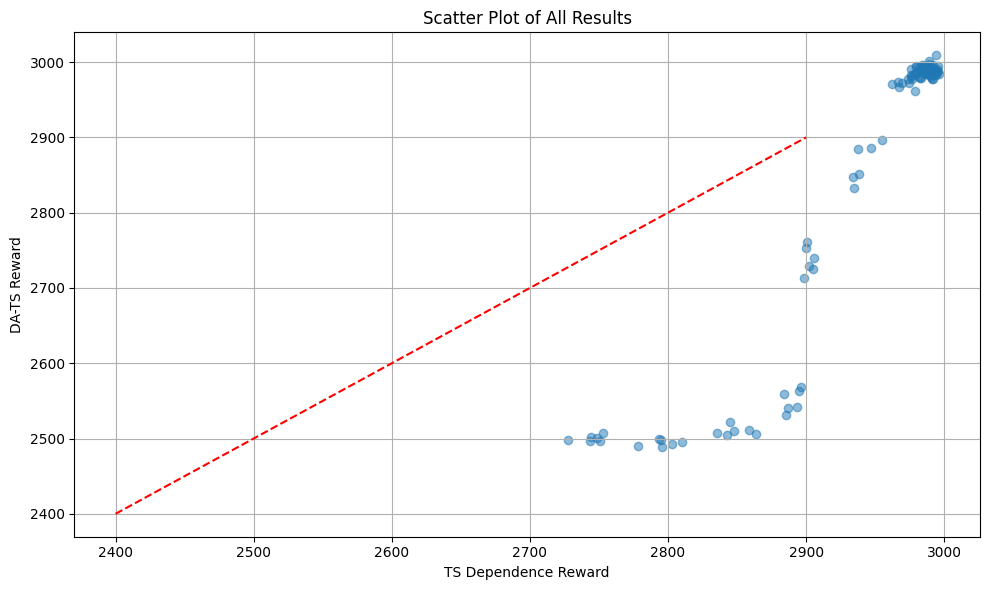

In [12]:
# True probabilities
theta1_true = 0.6
theta2_true = 0.4
theta0_true = 0.5 * theta1_true + 0.5 * theta2_true
theta0_true = min(max(theta0_true, 0.0), 1.0)
theta = [theta0_true, theta1_true, theta2_true]  # [0.5, 0.6, 0.4]

# Parameter ranges
alpha1_values = [1, 101, 201, 301, 401]
alpha2_values = [1, 2]
beta1_values = [1, 201, 401, 601]
beta2_values = [1, 2, 3]

N = 5000
repeat_time = 50
lam = 0.5

parameter_combinations = product(alpha1_values, alpha2_values, beta1_values, beta2_values)

# ---------- Running Both Algorithms ----------

results_ts_dependence = []  # For thompson_sampling_dependence
results_da_ts = []          # For dependency_aware_thompson_sampling

for alpha1_val, alpha2_val, beta1_val, beta2_val in parameter_combinations:
    # For thompson_sampling_dependence:
    alpha_init_ts = [alpha1_val, alpha2_val, alpha2_val]  # arm0, arm1, arm2 parameters
    beta_init_ts = [beta1_val, beta2_val, beta2_val]

    # For dependency_aware_thompson_sampling:
    # We'll follow the previous assumption: arm0 uses alpha1_val,beta1_val and arms1,2 use alpha2_val,beta2_val
    alpha_init_da = [alpha1_val, alpha2_val, alpha2_val]
    beta_init_da = [beta1_val, beta2_val, beta2_val]

    # Run trials for thompson_sampling_dependence
    total_reward_ts = 0.0
    for _ in range(repeat_time):
        reward = thompson_sampling_dependence(N, theta, alpha_init_ts, beta_init_ts)
        total_reward_ts += reward / repeat_time

    # Run trials for dependency_aware_thompson_sampling
    total_reward_da = 0.0
    for _ in range(repeat_time):
        reward = dependency_aware_thompson_sampling(N, theta, alpha_init_da, beta_init_da, lam)
        total_reward_da += reward / repeat_time

    results_ts_dependence.append((alpha1_val, alpha2_val, beta1_val, beta2_val, total_reward_ts))
    results_da_ts.append((alpha1_val, alpha2_val, beta1_val, beta2_val, total_reward_da))

# ---------- Find Best Parameters for Each Method ----------

best_ts = max(results_ts_dependence, key=lambda x: x[4])
best_da = max(results_da_ts, key=lambda x: x[4])

print("===== Thompson Sampling Dependence=====")
print("Best Parameters:")
print(f"Alpha1={best_ts[0]}, Alpha2={best_ts[1]}, Beta1={best_ts[2]}, Beta2={best_ts[3]}, Avg Reward={best_ts[4]:.2f}")

print("\n===== Dependency-Aware Thompson Sampling=====")
print("Best Parameters:")
print(f"Alpha1={best_da[0]}, Alpha2={best_da[1]}, Beta1={best_da[2]}, Beta2={best_da[3]}, Avg Reward={best_da[4]:.2f}")

# ---------- Plotting Subsets for Comparison ----------

result_dict_ts = {(r[0], r[1], r[2], r[3]): r[4] for r in results_ts_dependence}
result_dict_da = {(r[0], r[1], r[2], r[3]): r[4] for r in results_da_ts}

# Example: Fix alpha1=401, alpha2=2, beta2=3 and vary beta1
fixed_alpha1 = 401
fixed_alpha2 = 2
fixed_beta2 = 3

subset_beta1_ts = []
rewards_subset_beta_ts = []
subset_beta1_da = []
rewards_subset_beta_da = []

for b1 in beta1_values:
    key = (fixed_alpha1, fixed_alpha2, b1, fixed_beta2)
    if key in result_dict_ts:
        subset_beta1_ts.append(b1)
        rewards_subset_beta_ts.append(result_dict_ts[key])
    if key in result_dict_da:
        subset_beta1_da.append(b1)
        rewards_subset_beta_da.append(result_dict_da[key])
        
# Additional plotting functions
def plot_heatmap(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='viridis', aspect='auto')
    plt.colorbar(label='Average Total Reward')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def plot_parameter_comparison(param_values, ts_rewards, da_rewards, param_name):
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, ts_rewards, marker='o', linestyle='-', color='blue', label='TS Dependence')
    plt.plot(param_values, da_rewards, marker='s', linestyle='-', color='green', label='Dependency-Aware TS')
    plt.xlabel(param_name)
    plt.ylabel('Average Total Reward')
    plt.title(f"Comparison of {param_name} Impact")
    plt.grid(True)
    plt.legend()
    plt.show()

# 1. Heatmap for TS Dependence (Alpha1 vs Beta1)
heatmap_ts = np.zeros((len(alpha1_values), len(beta1_values)))
for i, alpha1 in enumerate(alpha1_values):
    for j, beta1 in enumerate(beta1_values):
        key = (alpha1, alpha2_values[0], beta1, beta2_values[0])
        if key in result_dict_ts:
            heatmap_ts[i, j] = result_dict_ts[key]

plot_heatmap(heatmap_ts, "TS Dependence: Alpha1 vs Beta1", "Beta1", "Alpha1")

# 2. Heatmap for DA-TS (Alpha1 vs Beta1)
heatmap_da = np.zeros((len(alpha1_values), len(beta1_values)))
for i, alpha1 in enumerate(alpha1_values):
    for j, beta1 in enumerate(beta1_values):
        key = (alpha1, alpha2_values[0], beta1, beta2_values[0])
        if key in result_dict_da:
            heatmap_da[i, j] = result_dict_da[key]

plot_heatmap(heatmap_da, "DA-TS: Alpha1 vs Beta1", "Beta1", "Alpha1")

# 3. Impact of Alpha1 (fixing other parameters)
fixed_alpha2, fixed_beta1, fixed_beta2 = alpha2_values[0], beta1_values[0], beta2_values[0]
alpha1_ts_rewards = [result_dict_ts.get((a1, fixed_alpha2, fixed_beta1, fixed_beta2), 0) for a1 in alpha1_values]
alpha1_da_rewards = [result_dict_da.get((a1, fixed_alpha2, fixed_beta1, fixed_beta2), 0) for a1 in alpha1_values]

plot_parameter_comparison(alpha1_values, alpha1_ts_rewards, alpha1_da_rewards, "Alpha1")

# 4. Impact of Beta1 (fixing other parameters)
fixed_alpha1, fixed_alpha2, fixed_beta2 = alpha1_values[0], alpha2_values[0], beta2_values[0]
beta1_ts_rewards = [result_dict_ts.get((fixed_alpha1, fixed_alpha2, b1, fixed_beta2), 0) for b1 in beta1_values]
beta1_da_rewards = [result_dict_da.get((fixed_alpha1, fixed_alpha2, b1, fixed_beta2), 0) for b1 in beta1_values]

plot_parameter_comparison(beta1_values, beta1_ts_rewards, beta1_da_rewards, "Beta1")

# 5. Performance difference heatmap (DA-TS - TS Dependence)
diff_heatmap = heatmap_da - heatmap_ts
plot_heatmap(diff_heatmap, "Performance Difference (DA-TS - TS Dependence)", "Beta1", "Alpha1")

# 6. Scatter plot of all results
plt.figure(figsize=(10, 6))
plt.scatter([r[4] for r in results_ts_dependence], [r[4] for r in results_da_ts], alpha=0.5)
plt.plot([2400, 2900], [2400, 2900], 'r--')  # Diagonal line for reference
plt.xlabel('TS Dependence Reward')
plt.ylabel('DA-TS Reward')
plt.title('Scatter Plot of All Results')
plt.grid(True)
plt.tight_layout()
plt.show()